In [9]:
using Catlab, Catlab.CategoricalAlgebra, Catlab.Programs, Catlab.WiringDiagrams
using AlgebraicPetri
using Catlab.Graphics.Graphviz

  Activating project at `~/Documents/AlgebraicJulia/Papers/2021-RoyalSoc`


In [193]:
# Functions for graphing typed Petri nets
colors = ["#cd9deb","#f5ebb5", "#34cfeb", "#f5ebb5", "#34cfeb"]

function def_trans(typed_petri::ACSetTransformation, colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? "$(tname(p, t))" : "" ,
             :shape=>"square",
             :color=>colors[typed_petri[:T](t)],
             :pos=>pos))
end

function def_trans(colors = colors; labels = true)
  (p, t; pos = "") -> ("t$t", Attributes(
             :label => labels ? "$(tname(p, t))" : "" ,
             :shape=>"square",
             :color=>colors[t],
             :pos=>pos))
end

Graph_typed(typed_petri::ACSetTransformation, colors = colors; labels = true) = Graph(dom(typed_petri),
    make_trans = def_trans(typed_petri, colors; labels = labels)
)


Graph_typed (generic function with 2 methods)

# Type systems for open Petri nets

## Typed Petri nets
We establish two Petri nets which are domain-specific type systems for Petri nets epidemiological modeling.
$P_\mathsf{infectious}$ represents a type system for infectious diseases while $P_\mathsf{vector-borne}$ respresents a types sytem for vector-borne diseases.

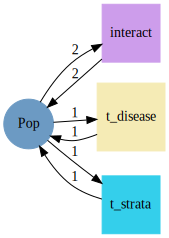

In [194]:
infectious_type = LabelledPetriNet([:Pop],
  :interact=>((:Pop, :Pop)=>(:Pop, :Pop)), 
  :t_disease=>(:Pop=>:Pop),
  :t_strata=>(:Pop=>:Pop)
)

Graph(infectious_type; make_trans = def_trans)

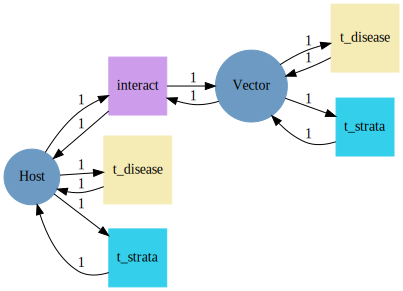

In [195]:
vector_borne_type = LabelledPetriNet([:Host, :Vector],
  :interact=>((:Host, :Vector)=>(:Host, :Vector)),
  :t_disease=>(:Host=>:Host),
  :t_strata=>(:Host=>:Host),
  :t_disease=>(:Vector=>:Vector),
  :t_strata=>(:Vector=>:Vector)
)

Graph(vector_borne_type; make_trans = def_trans())

A Petri net typed by $P_\mathsf{infectious}$ is a Petri net $P$ along with an etale map $P \to P_{\mathsf{infectious}}$,
which are captured by the data of an ACSetTransformation.

To make these ACSetTransformations easier to define we begin by extracting data from the type system $P_\mathsf{infectious}$.

In [163]:
s, = parts(infectious_type, :S)
t_interact, t_disease, t_strata = parts(infectious_type, :T)
i_interact1, i_interact2, i_disease, i_strata = parts(infectious_type, :I)
o_interact1, o_interact2, o_disease, o_strata = parts(infectious_type, :O);

infectious_type = map(infectious_type, Name=name->nothing); # remove names to allow for the loose ACSet transform to be natural

Our first example of a typed Petri net is the classic SIR model of disease infection.
There are three places which are typed by the single place type, and five transitions. The transition labeled `inf` represents an infection between a susceptible and an infected individual. The transition labeled `rec` represents recovery of an infected individual. The transitions labeled `id` represent identity transformations or no change in disease status. However, they are important because in a stratification they may be paired with transitions that represent spontaneous change in strata. 

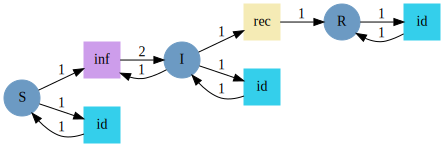

In [164]:
SIR = LabelledPetriNet([:S, :I, :R],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:R),
  :id => (:S => :S),
  :id => (:I => :I),
  :id => (:R => :R)
)

typed_SIR = ACSetTransformation(SIR, infectious_type,
  S = [s, s, s],
  T = [t_interact, t_disease, t_strata, t_strata, t_strata],
  I = [i_interact1, i_interact2, i_disease, i_strata, i_strata, i_strata],
  O = [o_interact1, o_interact2, o_disease, o_strata, o_strata, o_strata],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);


@assert is_natural(typed_SIR)

Graph_typed(typed_SIR)

Our second example is of a stratification scheme for stratification by quarantine status. It contains a population of quarantining individuals and a population of not-quarantining individuals.
Individuals can move between these strata and also undergo a spontaneous change in their infection status.
However, interaction-type transformations can only occur between two individuals in the non-quarantining population.

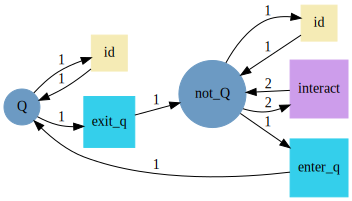

In [165]:
quarantine = LabelledPetriNet([:Q, :not_Q],
    :id => (:Q => :Q),
    :id => (:not_Q => :not_Q),
    :enter_q => (:not_Q => :Q),
    :exit_q => (:Q => :not_Q),
    :interact => ((:not_Q, :not_Q) => (:not_Q, :not_Q))
)

typed_quarantine = ACSetTransformation(quarantine, infectious_type,
    S = [s, s],
    T = [t_disease, t_disease, t_strata, t_strata, t_interact],
    I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2],
    O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2],
    Name = name -> nothing
)

@assert is_natural(typed_quarantine)

Graph_typed(typed_quarantine)

## Model stratification
### First example

First we give methods to produce the stratified model of two typed Petri nets.
`stratify` returns the stratified model while `typed_stratify` returns the stratified model along with a typing of it.

Mathematically, these operations correspond to pullbacks. The `pullback` method is implemented by Catlab.jl.

In [166]:
stratify(typed_model1, typed_model2) = ob(pullback(typed_model1, typed_model2))
typed_stratify(typed_model1, typed_model2) =
  compose(proj1(pullback(typed_model1, typed_model2)), typed_model1)

typed_stratify (generic function with 1 method)

We apply this method to the SIR and quarantining models. Note that the labels of the places and transitions are pairs with the first element in the pair representing information from the disease model and the second element in the pair representing information from the stratification scheme. For example, the place labeled `(:S, :not_Q)` represents the population of susceptible individuals who are not quarantining.  The transitions labeled `(:id, :exit_q)` represents no change (i.e. identity transformation) in disease status and a change in strata from quarantining to not quarantining. The transition labeled `(:inf, :interaction)` represents the infection interaction between two individuals who are not quarantining.

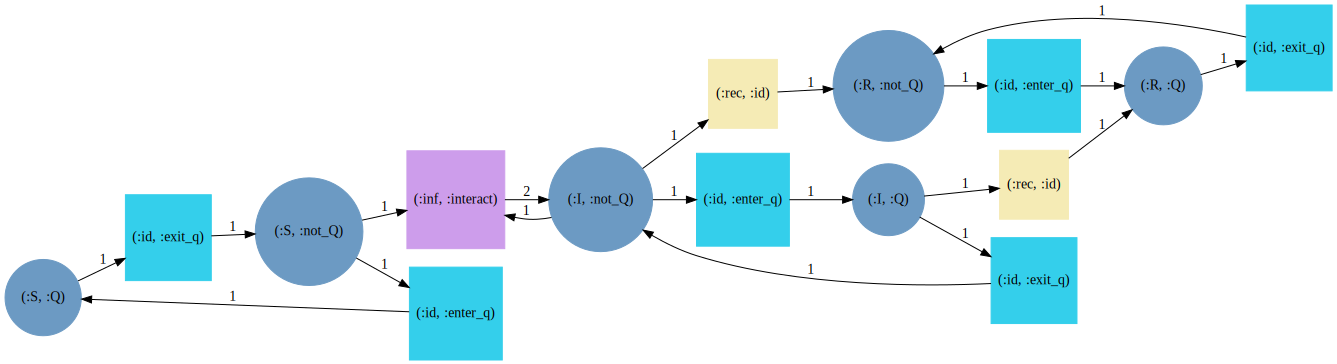

In [167]:
typed_stratified_model = typed_stratify(typed_SIR, typed_quarantine)
Graph_typed(typed_stratified_model)

## Example playground
Next we give a palette of disease models and a palette of stratification schemes.
These can be used to derive a number of stratified models as well as multiply-stratified models

#### Palette of disease models

Our second disease model is the Susceptible-Infected-Susceptible (SIS) model of disease infection, in which
there is no long-lasting immunity and a recovered indivdual is susceptible to reinfection.

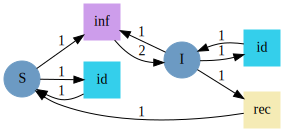

In [168]:
SIS = LabelledPetriNet([:S, :I],
  :inf => ((:S, :I)=>(:I, :I)),
  :rec => (:I=>:S),
  :id => (:S => :S),
  :id => (:I => :I),
)

typed_SIS = ACSetTransformation(SIS, infectious_type,
  S = [s, s],
  T = [t_interact, t_disease, t_strata, t_strata],
  I = [i_interact1, i_interact2, i_disease, i_strata, i_strata],
  O = [o_interact1, o_interact2, o_disease, o_strata, o_strata],
  Name = name -> nothing
);

@assert is_natural(typed_SIS)

Graph_typed(typed_SIS)

The third disease model is the SVIIvR model defined compositionally and discussed in detail in in XXX. Additionally, we add identity transformations between each place which are typed by spontaneous change in strata.

In [169]:
SVIIvR_composition_pattern = @relation (S, V, I, Iv, R) where (S, V, I, Iv, R) begin
  SIR(S, I, R)
  VIvR(V, Iv, R)
  cross_exposure(S, I, V, Iv)
end

SIR = Open(LabelledPetriNet([:S, :I, :R],
  :inf_uu => ((:S, :I) => (:I, :I)),
  :rec_u => (:I => :R)
))

VIvR = Open(LabelledPetriNet([:V, :Iv, :R],
  :inf_vv => ((:V, :Iv) => (:Iv, :Iv)),
  :rec_v => (:Iv => :R)
))

cross_exposure = Open(LabelledPetriNet([:S, :I, :V, :Iv],
  :inf_uv => ((:S, :Iv) => (:I, :Iv)),
  :inf_vu => ((:V, :I) => (:Iv, :I)),
  :vax => (:S => :V)
))

SVIIvR = oapply(SVIIvR_composition_pattern, Dict(
  :SIR => SIR,
  :VIvR => VIvR,
  :cross_exposure => cross_exposure
)) |> apex;

In [170]:
ts = add_transitions!(SVIIvR, ns(SVIIvR), tname = :id)
add_inputs!(SVIIvR, ns(SVIIvR), ts, 1:ns(SVIIvR))
add_outputs!(SVIIvR, ns(SVIIvR), ts, 1:ns(SVIIvR))

12:16

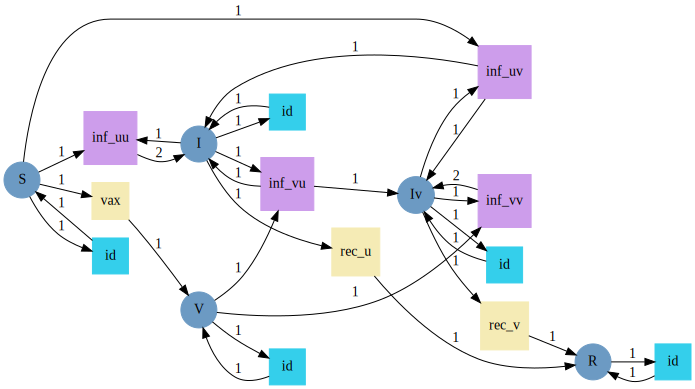

In [171]:
typed_SVIIvR = ACSetTransformation(SVIIvR, infectious_type,
  S = [s, s, s, s, s],
  T = vcat([t_interact, t_disease, t_interact, t_disease,  t_interact, t_interact, t_disease], repeat([t_strata], 5)),
  I = vcat([i_interact1, i_interact2, i_disease, i_interact1, i_interact2, i_disease, i_interact1, i_interact2, i_interact1, i_interact2, i_disease], repeat([i_strata], 5)),
  O = vcat([o_interact1, o_interact2, o_disease, o_interact1, o_interact2, o_disease, o_interact1, o_interact2, o_interact1, o_interact2, o_disease], repeat([o_strata], 5)),
  Name = name -> nothing
);

@assert is_natural(typed_SVIIvR)

Graph_typed(typed_SVIIvR)

This gives us a palette of disease models.

In [172]:
disease_models = Dict(
  :SIR => typed_SIR,
  :SIS => typed_SIS,
  :SVIIvR => typed_SVIIvR,
);

We can stratify each of these disease models by the model of quarantining. Note that we omit the labels on the transition to reduce the size of the Petri net. Recall that blue transitions correspond to spontaneous changes in strata, yellow transitions correspond to spontaneous changes in disease status, and purple transitions correspond to interactions.

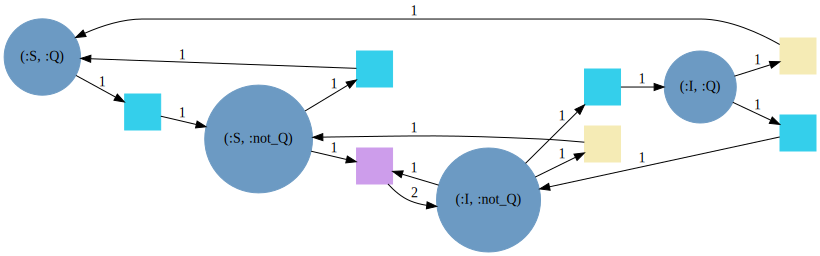

In [173]:
typed_model = typed_stratify(disease_models[:SIS], typed_quarantine)
Graph_typed(typed_model; labels = false)

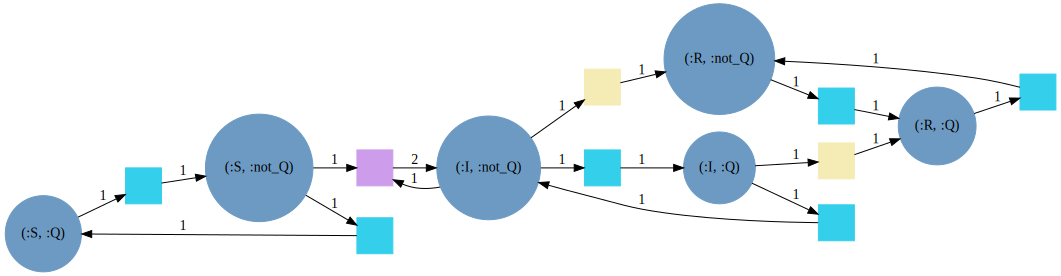

In [174]:
typed_model = typed_stratify(disease_models[:SIR], typed_quarantine)
Graph_typed(typed_model; labels = false)

### Palette of stratification schemes

Our second stratification scheme is a stratification by age. In this model, individuals cannot move between strata.
Individuals can  undergo a spontaneous change in their infection status as well as interact with other individuals in their strata.
Adults and children can also interact. However, the mapping of the input arcs asserts that children infect adults and not vice versa.

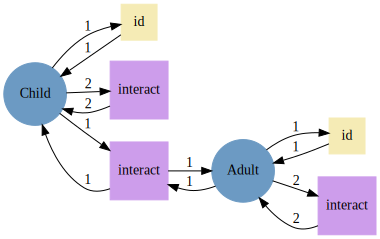

In [175]:
age_stratification = LabelledPetriNet([:Child, :Adult],
    :id => (:Child => :Child),
    :id => (:Adult => :Adult),
    :interact => ((:Child, :Child) => (:Child, :Child)),
    :interact => ((:Adult, :Adult) => (:Adult, :Adult)),
    :interact => ((:Child, :Adult) => (:Child, :Adult))
)

typed_age = ACSetTransformation(age_stratification, infectious_type,
  S = [s, s],
  T = [t_disease, t_disease, t_interact, t_interact, t_interact],
  I = [i_disease, i_disease, i_interact1, i_interact2, i_interact1, i_interact2, i_interact2, i_interact1],
  O = [o_disease, o_disease, o_interact1, o_interact2, o_interact1, o_interact2, o_interact2, o_interact1],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_age)

Our final two stratification schemes are spatial stratifications with population dynamics, which were studied in Citron et. al, 2021. For the flux model of spatial dynamics individuals move between patches and only individuals in the same patch can interact.

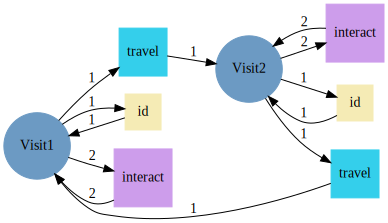

In [176]:
flux_metapopulation = LabelledPetriNet([:Visit1, :Visit2],
    :travel => (:Visit1 => :Visit2),
    :travel => (:Visit2 => :Visit1),
    :id => (:Visit1 => :Visit1),
    :id => (:Visit2 => :Visit2),
    :interact => ((:Visit1, :Visit1) => (:Visit1, :Visit1)),
    :interact => ((:Visit2, :Visit2) => (:Visit2, :Visit2))
)

typed_flux = ACSetTransformation(flux_metapopulation, infectious_type,
  S = [s, s],
  T = [t_strata, t_strata, t_disease, t_disease, t_interact, t_interact],
  I = [i_strata, i_strata, i_disease, i_disease, i_interact1, i_interact2, i_interact1, i_interact2],
  O = [o_strata, o_strata, o_disease, o_disease, o_interact1, o_interact2, o_interact1, o_interact2],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_flux)

For the simple trip model of spatial dynamics, individuals are associated to two patches: a "home" patch
and a "currently visiting" patch. Individuals can spontaneously move between visiting a patch and returning home,
but they cannot change which patch they live in. Only individuals visiting the same patch can interact.
This model involves $N^2$ places and $O(N^2)$ transitions where $N$ is the number of patches. to
reduce the complexity of building this model, we build it as the stratification of a model of where individuals live
by the flux model shown above.  This example, highlights
that stratified models can be build *hierarchically* in that a stratification scheme can itself be a stratified model. 

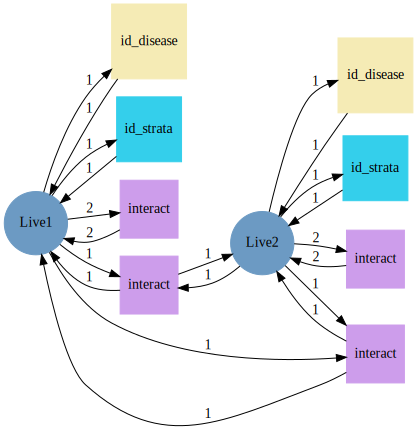

In [177]:
living_model = LabelledPetriNet([:Live1, :Live2],
    :id_disease => (:Live1, :Live1),
    :id_disease => (:Live2, :Live2),
    :id_strata => (:Live1, :Live1),
    :id_strata => (:Live2, :Live2),
    :interact => ((:Live1, :Live1) => (:Live1, :Live1)),
    :interact => ((:Live2, :Live2) => (:Live2, :Live2)),
    :interact => ((:Live1, :Live2) => (:Live1, :Live2)),
    :interact => ((:Live2, :Live1) => (:Live2, :Live1))
)

typed_living = ACSetTransformation(living_model, infectious_type,
  S = [s, s],
  T = [t_disease, t_disease, t_strata, t_strata, t_interact, t_interact, t_interact, t_interact],
  I = [i_disease, i_disease, i_strata, i_strata, i_interact1, i_interact2, i_interact1, i_interact2, i_interact1, i_interact2, i_interact1, i_interact2],
  O = [o_disease, o_disease, o_strata, o_strata, o_interact1, o_interact2, o_interact1, o_interact2, o_interact1, o_interact2, o_interact1, o_interact2],
  Name = name -> nothing # specify the mapping for the loose ACSet transform
);

Graph_typed(typed_living)

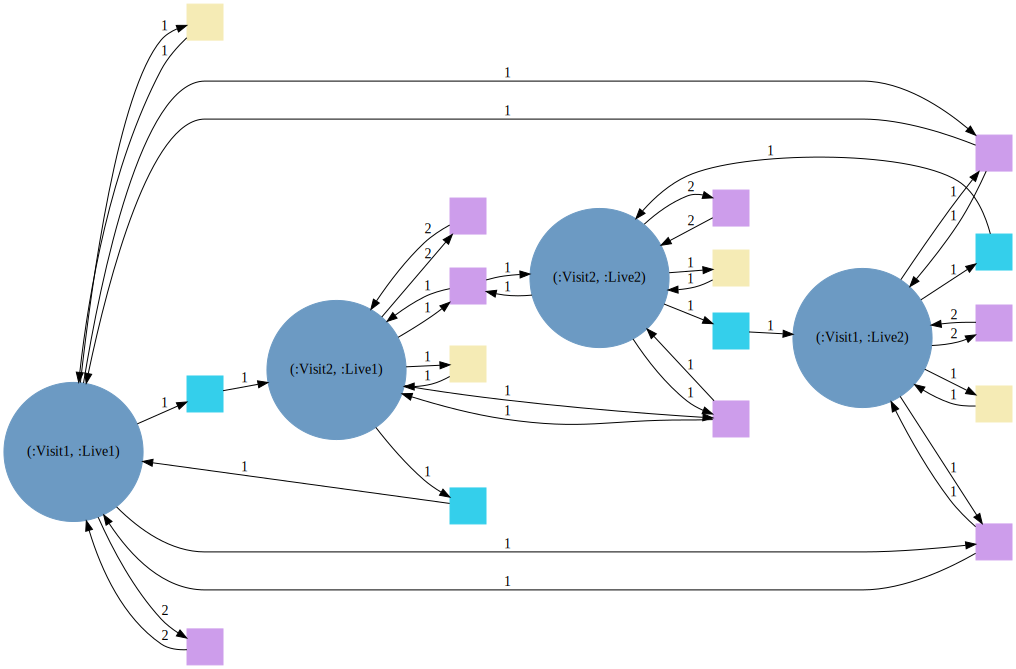

In [178]:
typed_simple_trip = typed_stratify(typed_flux, typed_living)

simple_trip = stratify(typed_flux, typed_living)

Graph_typed(typed_simple_trip; labels = false)

This gives us a palette of stratification schemes

In [179]:
stratification_scheme = Dict(
  :quarantine => typed_quarantine,
  :age => typed_age,
  :flux => typed_flux,
  :simple_trip => typed_simple_trip,
);

### Stratified models
Now we can stratify any disease model by any stratification scheme. For example, we can stratify the SVIIvR disease model by the age stratification scheme.

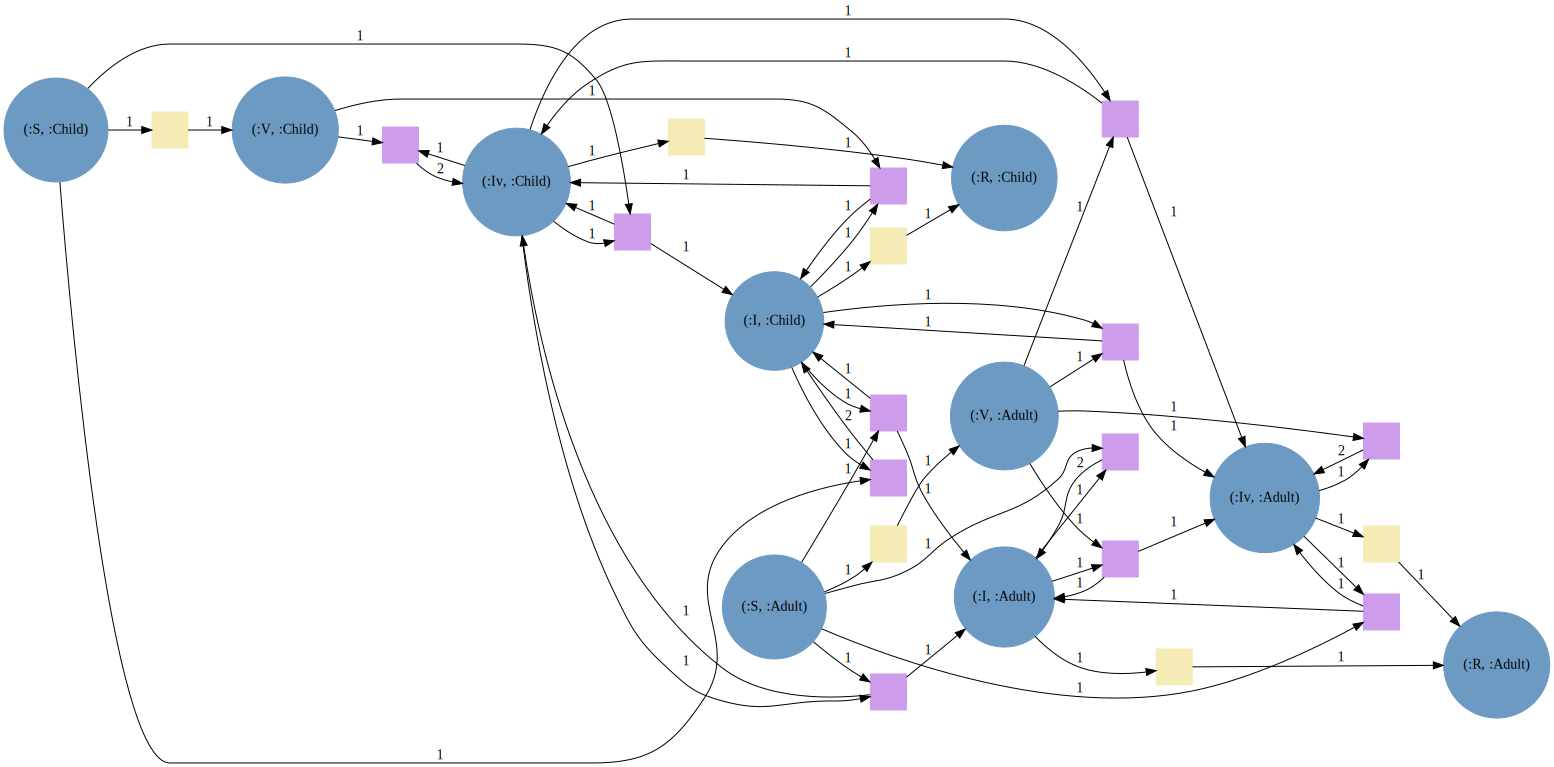

In [180]:
typed_model = typed_stratify(disease_models[:SVIIvR], stratification_scheme[:age])
Graph_typed(typed_model; labels = false)

The process of model stratification automates the by-hand approach taken in Citron et. al, 2021 for combining candidate disease models with candidate movement models in order to test against real-world data. 

Below we show that the Petri nets for SIR and SIS disease dynamics stratified by the flux and simple trip movement models are automatically generated by our approach. When the law of mass action is applied to these Petri nets, we recover the ODEs in Equations 6, 7, 9, and 10 of  Citron et. al, 2021 modulo the treatment of total vs. proportional populations.

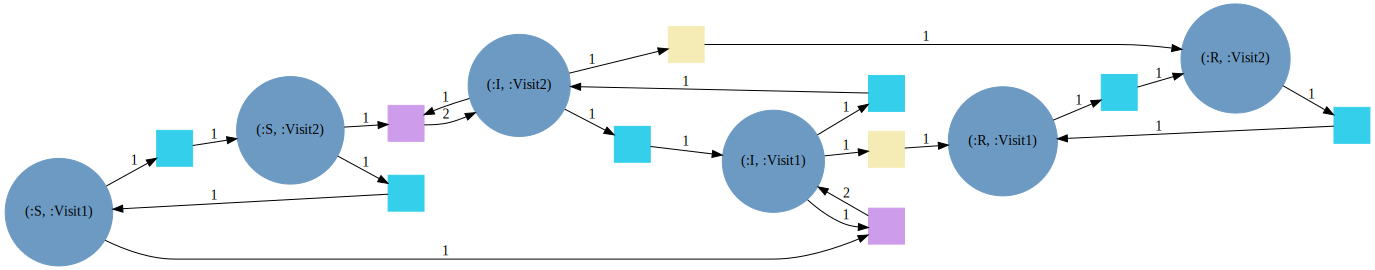

In [181]:
typed_SIR_flux = typed_stratify(disease_models[:SIR], stratification_scheme[:flux]) 
Graph_typed(typed_SIR_flux; labels = false)

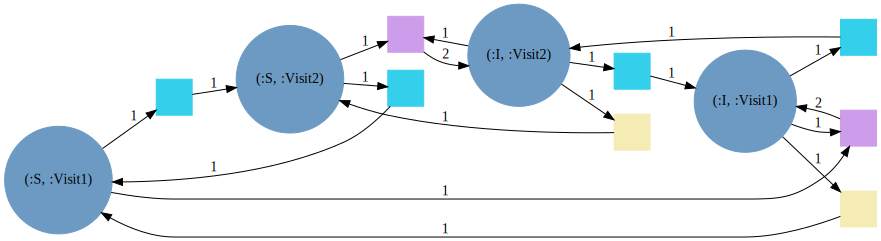

In [182]:
typed_SIS_flux = typed_stratify(disease_models[:SIS], stratification_scheme[:flux]) 
Graph_typed(typed_SIS_flux; labels = false)

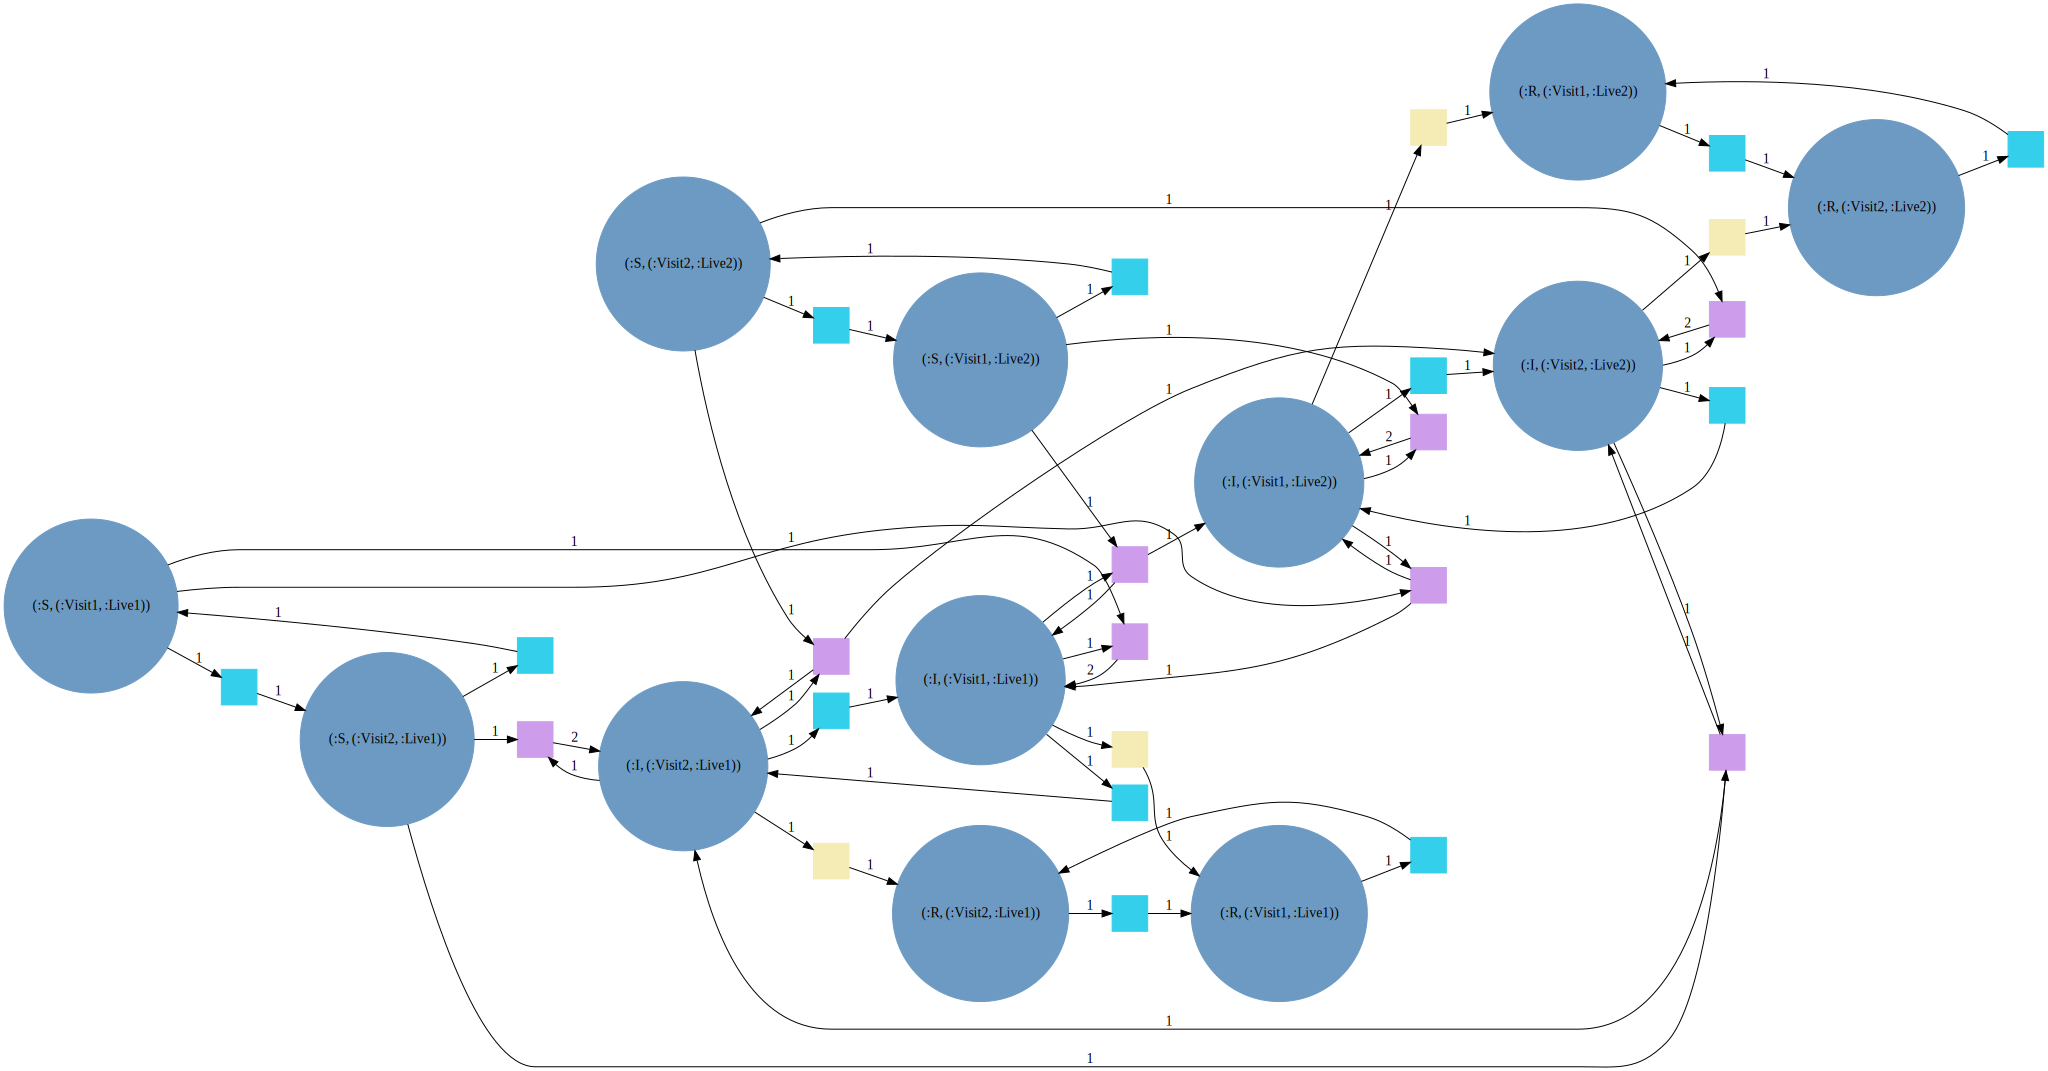

In [183]:
typed_SIR_simple_trip = typed_stratify(disease_models[:SIR], stratification_scheme[:simple_trip]) 
Graph_typed(typed_SIR_simple_trip; labels = false)

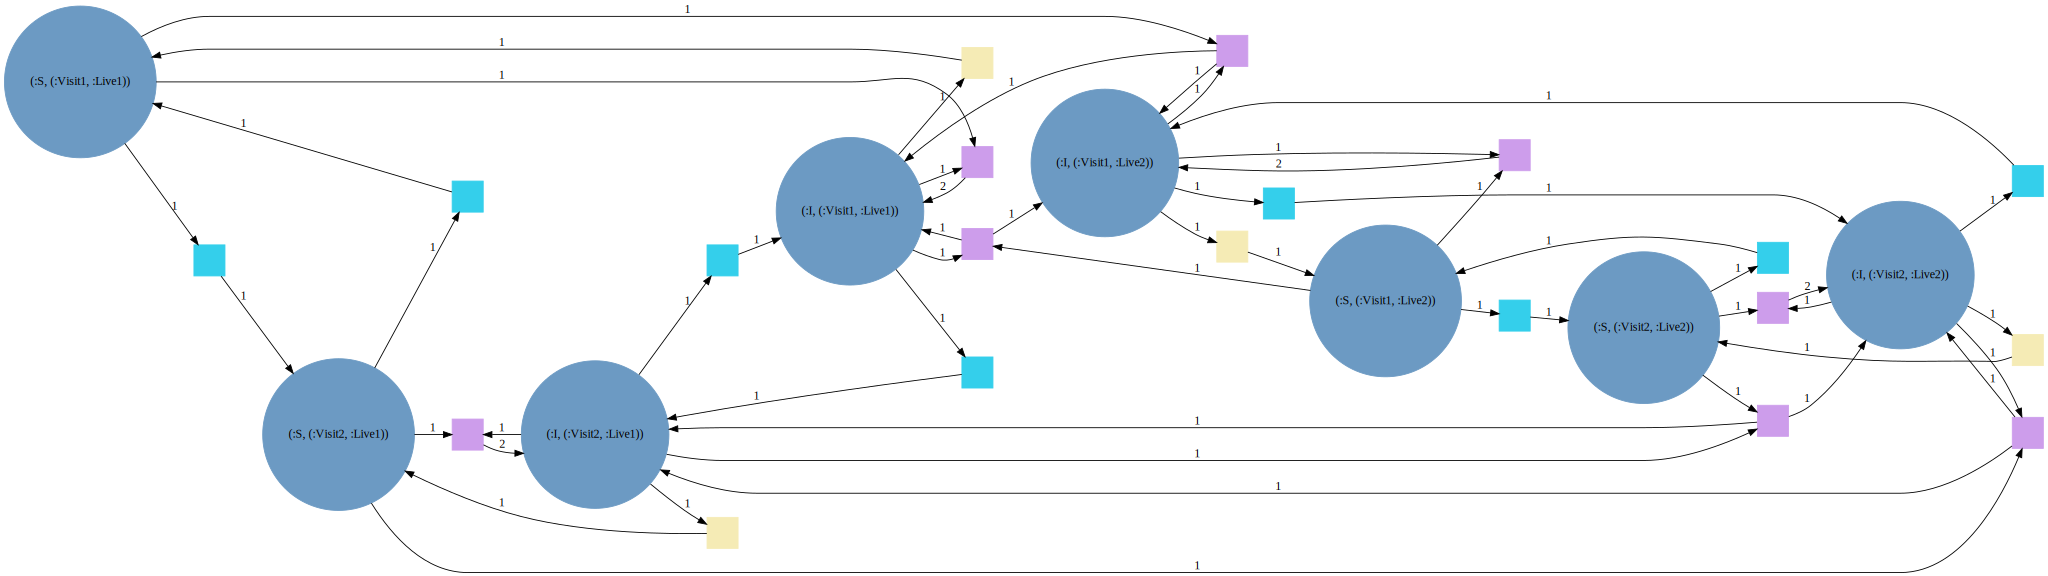

In [184]:
typed_SIS_simple_trip = typed_stratify(disease_models[:SIS], stratification_scheme[:simple_trip]) 
Graph_typed(typed_SIS_simple_trip; labels = false)

The SIR and SIS simple trip models we call multiply-stratified or hierarchically-stratified models because the simple trip model is itself a stratified model. Fully decomposed, the SIS simple trip model is a 3-way stratification of the SIR disease model, the flux model, and a model of where individuals live. An important property guaranteed by the categorical formalism is that the order of stratification does not affect the final model. For example, the Petri net below is isomorphic to the Petri net given in `SIS_simple_trip` above.

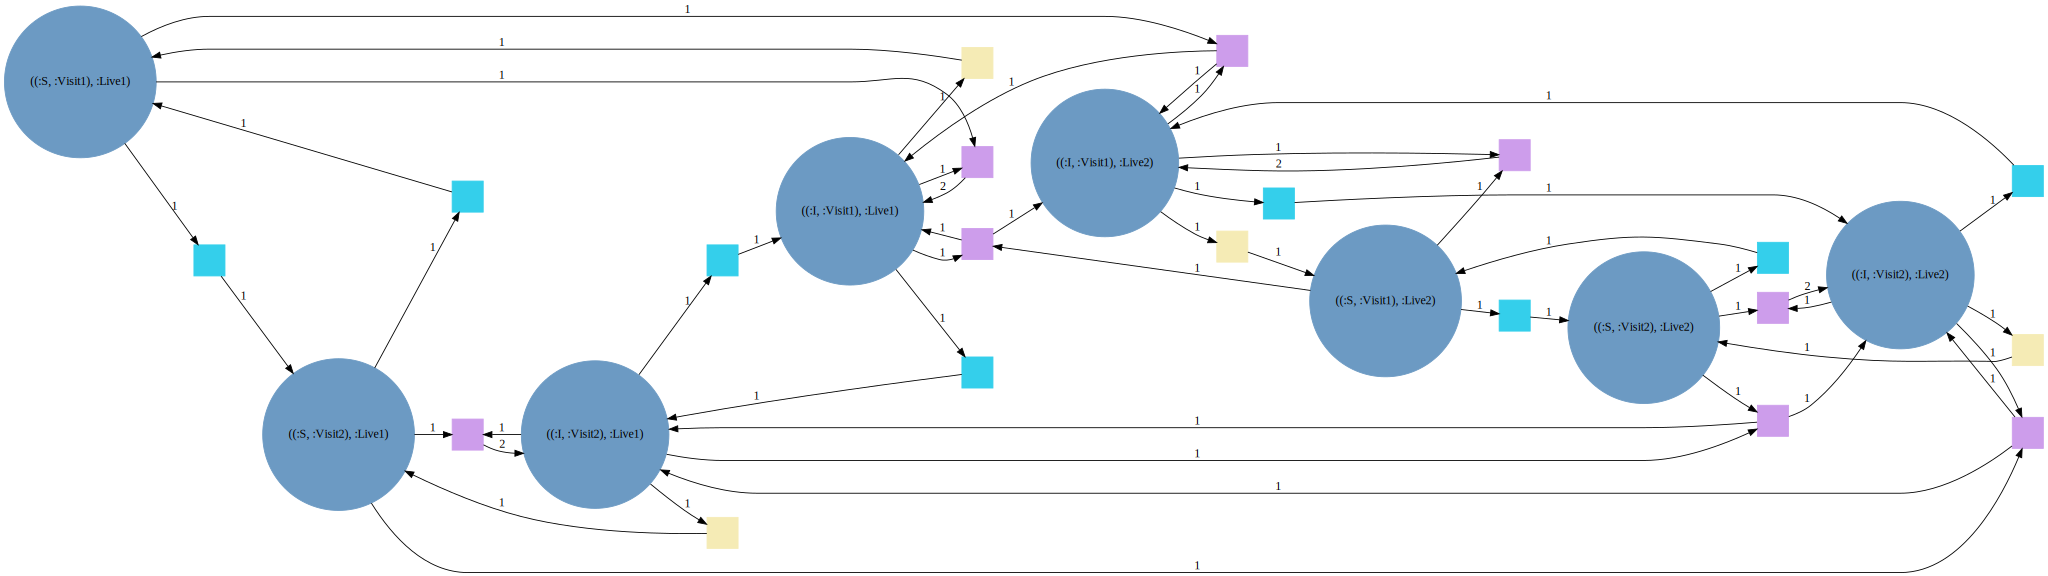

In [186]:
typed_SIS_simple_trip2 = typed_stratify(
  typed_stratify(disease_models[:SIS], stratification_scheme[:flux]), 
  typed_living
)
Graph_typed(typed_SIS_simple_trip2; labels = false)

#### References

Citron, Daniel T., et al. "Comparing metapopulation dynamics of infectious diseases under different models of human movement." _Proceedings of the National Academy of Sciences_ 118.18 (2021).